# DualCellQuant バッチ処理 (Step-by-Step)

大量の顕微鏡画像を連続処理するためのノートブック

## 処理フロー
1. 画像ファイルの読み込み
2. Cellpose-SAM セグメンテーション
3. Target/Reference マスク適用
4. 定量化 (Quantification)
5. Radial Profile 解析
6. Peak Difference 解析

## 1. セットアップ

In [1]:
import os
import sys
import glob
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm



# DualCellQuantモジュールをインポート
# testディレクトリから1つ上の階層のdualcellquantパッケージをインポート
parent_dir = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent
sys.path.insert(0, str(parent_dir))

from dualcellquant.core import (
    run_segmentation,
    apply_mask,
    integrate_and_quantify,
)
from dualcellquant.radial import (
    radial_mask,
    radial_profile_all_cells,
    compute_radial_peak_difference,
)
from dualcellquant.tracking import (
    relabel_to_previous,
)
from dualcellquant.visualization import (
    plot_radial_profile_with_peaks,
)

print("セットアップ完了")
print(f"DualCellQuantパス: {parent_dir}")


セットアップ完了
DualCellQuantパス: e:\Data\App\Python\dualCellQuant


In [2]:
# Jupyter Notebookでmatplotlibを表示するための設定
%matplotlib inline

## 2. パラメータ設定

In [3]:



# ========== セグメンテーションパラメータ ==========
SEG_PARAMS = {
    'source': 'reference',  # 'target' or 'reference'
    'channel': 'gray',   # 'gray', 'R', 'G', 'B'
    'diameter': 100,       # 0 = auto
    'flow_threshold': 0.4,
    'cellprob_threshold': 1,
    'use_gpu': True,
    # New: edge-touching 除外の制御
    'drop_edge_cells': True,
    'inside_fraction_min': 0.98,  # 画面内に98%以上あれば採用
    'edge_margin_pct': 1.0,       # 端からのマージン[%]
}

# ========== マスクパラメータ ==========
TARGET_MASK_PARAMS = {
    'channel': 'gray',
    'mode': 'none',  # 'none', 'global_percentile', 'global_otsu', 'per_cell_percentile', 'per_cell_otsu'
    'percentile': 75.0,
    'saturation_limit': 255,
    'min_object_size': 50,
}

REFERENCE_MASK_PARAMS = {
    'channel': 'gray',
    'mode': 'none',
    'percentile': 75.0,
    'saturation_limit': 255,
    'min_object_size': 50,
}

# ========== Radial Maskパラメータ ==========
RADIAL_MASK_PARAMS = {
    'inner_pct': 90.0,  # 内側の境界（%、0=中心、100=細胞境界）
    'outer_pct': 100.0,  # 外側の境界（%）
    'min_object_size': 50,  # 最小オブジェクトサイズ
}

# ========== 前処理パラメータ ==========
PREPROCESS_PARAMS = {
    'bg_enable': True,
    'bg_mode': 'dark_subtract',  # 'rolling', 'dark_subtract', 'manual'
    'bg_radius': 50,
    'bg_dark_pct': 5.0,
    'norm_enable': False,
    'norm_method': 'min-max',  # 'z-score', 'robust z-score', 'min-max', 'percentile [1,99]'
    'manual_tar_bg': None,
    'manual_ref_bg': None,
}

# ========== 定量化パラメータ ==========
QUANT_PARAMS = {
    'ratio_epsilon': 1e-6,
    'pixel_width_um': 0.207,
    'pixel_height_um': 0.207,
}

# ========== Radial Profileパラメータ ==========
RADIAL_PARAMS = {
    'start_pct': 0.0,
    'end_pct': 150.0,
    'window_size_pct': 5.0,
    'window_step_pct': 1.0,
}

# ========== Peak Differenceパラメータ ==========
PEAK_PARAMS = {
    'algo': 'first_local_top',  # 'first_local_top', 'global_max'
    'min_pct': 60.0,
    'max_pct': 100.0,
    # New: Savitzky–Golay smoothing と検出感度
    'sg_window': 5,
    'sg_poly': 2,
    'peak_slope_eps_rel': 0.001,
}

# ========== トラッキング（ID維持） ==========
TRACKING_PARAMS = {
    'enable': True,           # Trueで同一サンプル内フレーム間でID維持
    'iou_threshold': 0.05,     # IoUマッチのしきい値    
}
# ---- 任意の prev_labels TIFF を使う設定（オプション）----
# mode: 'auto' → 前フレームの結果を使用（既定） / 'tiff' → 下記パスのTIFFを使用
TRACKING_INPUT = {
    'mode': 'tiff',                 # 'auto' or 'tiff'
    'tiff_path': r'E:\\Data\\App\\Python\\dualCellQuant\\test\\FKBP12\\解析用データ\\4h.0_Z003_cell_masks.tif'  # 例: r"E:\\path\\to\\prev_labels.tif"
}

print("パラメータ設定完了")

パラメータ設定完了


In [4]:

def load_label_tiff(path: str):
    """
    ラベルTIFFをnp.ndarray(int32)として読み込み。
    2Dを想定。もし3Dなら先頭チャネルを使用。
    """
    try:
        if not path:
            return None
        if not os.path.isfile(path):
            print(f"[WARN] prev_labels TIFFが見つかりません: {path}")
            return None
        im = Image.open(path)
        arr = np.array(im)
        if arr.ndim == 3:
            arr = arr[:, :, 0]
        return arr.astype(np.int32, copy=False)
    except Exception as e:
        print(f"[WARN] prev_labels TIFFの読み込みに失敗: {e}")
        return None


新機能説明
 - drop_edge_cells / inside_fraction_min / edge_margin_pct: 端に触れる細胞除外の柔軟化
 - TRACKING_PARAMS.enable: 同一サンプル内(Zスライスなど)でIDを維持 (IoUによる再ラベル)
 - PEAK_PARAMS.sg_window / sg_poly / peak_slope_eps_rel: Radial profileをSG平滑後に first_local_top でピーク検出
処理フロー: Segmentation → (ID維持) → Mask → Quantify → Radial Mask → Radial Profile (RAW) → SG + Peak Difference


## 3. 画像ファイルリストの作成

In [5]:
# ========== 入力ファイル設定 ==========
# 画像ディレクトリ（再帰的に検索）
INPUT_DIR = r"E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ"

# Target/Referenceの識別パターン（正規表現）
TARGET_PATTERN = r"(.+)_C001(Z\d+)\.tif"  # Target画像のパターン
REFERENCE_PATTERN = r"(.+)_C002(Z\d+)\.tif"  # Reference画像のパターン

# 出力ディレクトリ
OUTPUT_DIR = r"E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_for_article"

print("入出力設定完了")
print(f"入力ディレクトリ: {INPUT_DIR}")
print(f"出力ディレクトリ: {OUTPUT_DIR}")

入出力設定完了
入力ディレクトリ: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ
出力ディレクトリ: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_for_article


In [6]:
import re

# 再帰的に.tifファイルを検索してペアを作成
def find_image_pairs(input_dir, target_pattern, reference_pattern):
    """
    指定ディレクトリから再帰的にTIFファイルを検索し、
    Target/Referenceのペアを抽出
    """
    target_re = re.compile(target_pattern)
    reference_re = re.compile(reference_pattern)
    
    # すべてのtifファイルを再帰的に検索
    all_tifs = []
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith('.tif') or file.lower().endswith('.tiff'):
                full_path = os.path.join(root, file)
                all_tifs.append(full_path)
    
    print(f"検索完了: {len(all_tifs)} 個のTIFファイルを発見")
    
    # Targetファイルを抽出
    target_files = {}
    for path in all_tifs:
        filename = os.path.basename(path)
        match = target_re.match(filename)
        if match:
            # グループ1: ベース名、グループ2: Z番号
            base = match.group(1)
            z_num = match.group(2) if len(match.groups()) > 1 else ""
            key = (base, z_num)
            target_files[key] = path
    
    # Referenceファイルを抽出
    reference_files = {}
    for path in all_tifs:
        filename = os.path.basename(path)
        match = reference_re.match(filename)
        if match:
            base = match.group(1)
            z_num = match.group(2) if len(match.groups()) > 1 else ""
            key = (base, z_num)
            reference_files[key] = path
    
    # ペアを作成
    pairs = []
    for key in sorted(target_files.keys()):
        if key in reference_files:
            pairs.append((target_files[key], reference_files[key]))
        else:
            print(f"  警告: Target {key} に対応するReferenceが見つかりません")
    
    # Referenceのみのファイルをチェック
    for key in reference_files.keys():
        if key not in target_files:
            print(f"  警告: Reference {key} に対応するTargetが見つかりません")
    
    return pairs

# 画像ペアを自動検出
IMAGE_PAIRS = find_image_pairs(INPUT_DIR, TARGET_PATTERN, REFERENCE_PATTERN)

print(f"\n処理対象: {len(IMAGE_PAIRS)} ペアの画像")
for i, (tgt, ref) in enumerate(IMAGE_PAIRS[:5], 1):  # 最初の5ペアを表示
    print(f"  {i}. Target: {Path(tgt).name}")
    print(f"     Reference: {Path(ref).name}")
if len(IMAGE_PAIRS) > 5:
    print(f"  ... 他 {len(IMAGE_PAIRS) - 5} ペア")

検索完了: 489 個のTIFファイルを発見

処理対象: 32 ペアの画像
  1. Target: 4h.0_C001Z001.tif
     Reference: 4h.0_C002Z001.tif
  2. Target: 4h.0_C001Z002.tif
     Reference: 4h.0_C002Z002.tif
  3. Target: 4h.0_C001Z003.tif
     Reference: 4h.0_C002Z003.tif
  4. Target: 4h.0_C001Z004.tif
     Reference: 4h.0_C002Z004.tif
  5. Target: 4h.0.5_C001Z001.tif
     Reference: 4h.0.5_C002Z001.tif
  ... 他 27 ペア


## 4. 出力ディレクトリの作成

In [7]:
# 出力ディレクトリを作成
# 構造:
# Results/
#   ├── sample1/
#   │   ├── masks/
#   │   ├── overlays/
#   │   ├── radial_profile_plots/
#   │   ├── quantification.csv
#   │   ├── radial_profiles.csv
#   │   └── peak_differences.csv
#   ├── sample2/
#   │   └── ...
#   ├── all_samples_quantification.csv
#   └── all_samples_peak_differences.csv

os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"出力ディレクトリ: {OUTPUT_DIR}")



出力ディレクトリ: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\Results_for_article


## 5. 単一画像ペアの処理（テスト用）

まず1つの画像ペアで処理をテストします

In [8]:
IMAGE_PAIRS[29]

('E:\\Data\\App\\Python\\dualCellQuant\\test\\FKBP12\\解析用データ\\4h.5.0.tif.frames\\4h.5.0_C001Z002.tif',
 'E:\\Data\\App\\Python\\dualCellQuant\\test\\FKBP12\\解析用データ\\4h.5.0.tif.frames\\4h.5.0_C002Z002.tif')

In [9]:
# テスト用に最初の1ペアを選択
if IMAGE_PAIRS:
    test_target, test_reference = IMAGE_PAIRS[29]
    print(f"テスト画像:")
    print(f"  Target: {test_target}")
    print(f"  Reference: {test_reference}")
else:
    print("画像ペアが見つかりません。IMAGE_PAIRS を設定してください。")

# ファイル名のベースを生成
def generate_base_name(target_path, target_pattern):
    """
    Targetファイルパスとパターンからbase_nameを生成
    """
    filename = os.path.basename(target_path)
    match = re.match(target_pattern, filename)
    if match:
        # グループ1: ベース名、グループ2: Z番号
        base = match.group(1)
        z_num = match.group(2) if len(match.groups()) > 1 else ""
        # Z番号を含めたbase_name
        return f"{base}_{z_num}" if z_num else base
    else:
        # パターンにマッチしない場合は拡張子を除いたファイル名
        return Path(target_path).stem

base_name = generate_base_name(test_target, TARGET_PATTERN)
print(f"Base name: {base_name}")

# サンプル用の出力ディレクトリを作成
sample_output_dir = os.path.join(OUTPUT_DIR, base_name)

テスト画像:
  Target: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\4h.5.0.tif.frames\4h.5.0_C001Z002.tif
  Reference: E:\Data\App\Python\dualCellQuant\test\FKBP12\解析用データ\4h.5.0.tif.frames\4h.5.0_C002Z002.tif
Base name: 4h.5.0_Z002


### Step 1: 画像の読み込み

Target画像サイズ: (1024, 1024)
Reference画像サイズ: (1024, 1024)


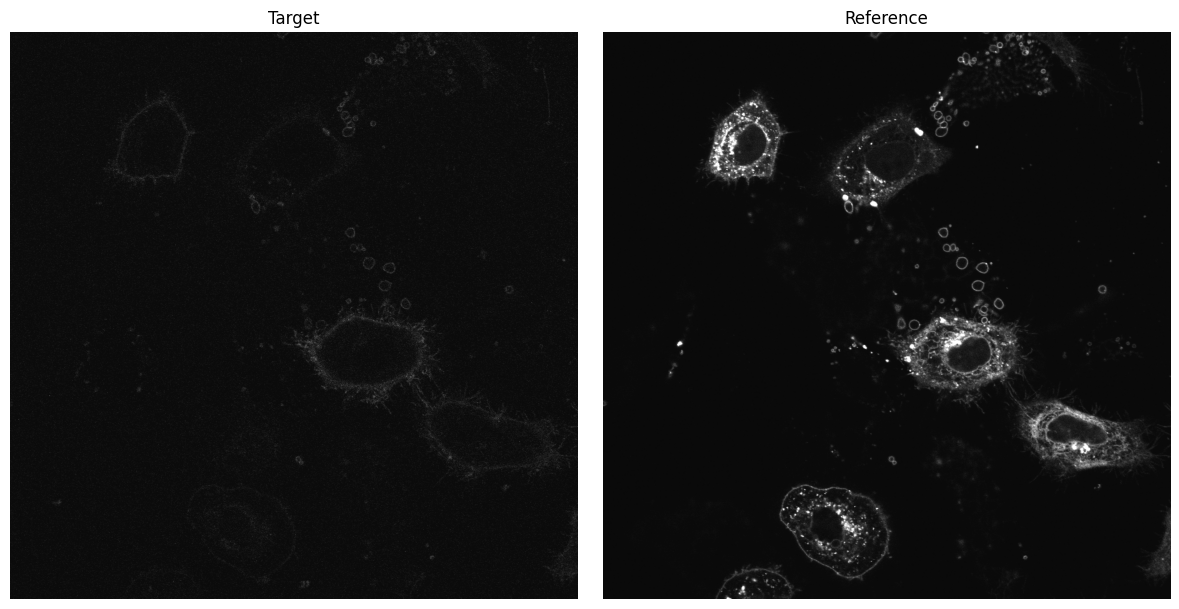

In [10]:
# 画像を読み込み
target_img = Image.open(test_target)
reference_img = Image.open(test_reference)

# RGBに変換（グレースケールの場合）
if target_img.mode != 'RGB':
    target_img = target_img.convert('RGB')
if reference_img.mode != 'RGB':
    reference_img = reference_img.convert('RGB')

print(f"Target画像サイズ: {target_img.size}")
print(f"Reference画像サイズ: {reference_img.size}")

# 画像を表示
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(target_img)
axes[0].set_title('Target')
axes[0].axis('off')
axes[1].imshow(reference_img)
axes[1].set_title('Reference')
axes[1].axis('off')
plt.tight_layout()
plt.show()

### Step 2: Cellpose-SAM セグメンテーション

channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
Resizing is deprecated in v4.0.1+


prev_labels TIFFによるID維持を適用しました（5件マッピング）
検出された細胞数: 5


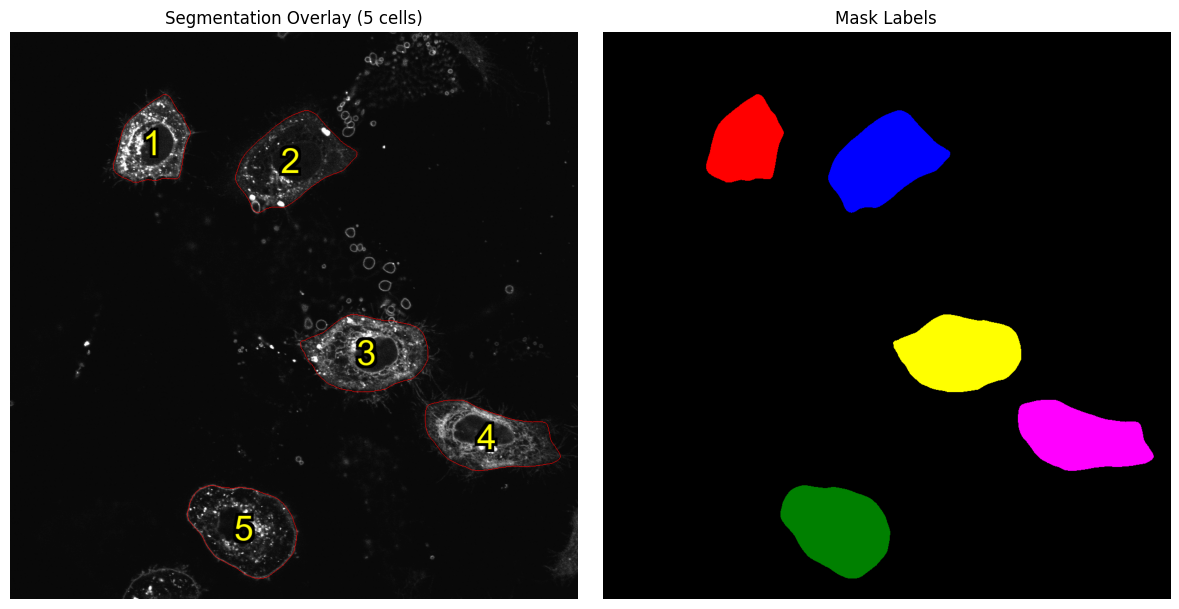

In [11]:
# セグメンテーション実行 (edge除外パラメータを追加)
seg_overlay, seg_tiff, mask_img, masks = run_segmentation(
    target_img,
    reference_img,
    seg_source=SEG_PARAMS['source'],
    seg_channel=SEG_PARAMS['channel'],
    diameter=SEG_PARAMS['diameter'],
    flow_threshold=SEG_PARAMS['flow_threshold'],
    cellprob_threshold=SEG_PARAMS['cellprob_threshold'],
    use_gpu=SEG_PARAMS['use_gpu'],
    drop_edge_cells=SEG_PARAMS['drop_edge_cells'],
    inside_fraction_min=SEG_PARAMS['inside_fraction_min'],
    edge_margin_pct=SEG_PARAMS['edge_margin_pct'],
)

# オプション: 任意のprev_labels TIFFからID維持を適用
if TRACKING_PARAMS['enable']:
    prev_labels = None
    if TRACKING_INPUT.get('mode') == 'tiff' and TRACKING_INPUT.get('tiff_path'):
        try:
            prev_labels = load_label_tiff(TRACKING_INPUT['tiff_path'])
        except Exception as e:
            print(f"[WARN] prev_labels TIFFの読み込みに失敗: {e}")
        
        if prev_labels is not None:
            # UI版と同じ前処理: ndim, dtype, shape確認
            if prev_labels.ndim != 2:
                prev_labels = np.squeeze(prev_labels)
            prev_labels = prev_labels.astype(np.int32, copy=False)
            curr_masks = masks.astype(np.int32, copy=False)
            
            if prev_labels.shape != curr_masks.shape:
                print(f"[WARN] prev_labels TIFFのサイズが不一致のため無視: {prev_labels.shape} != {curr_masks.shape}")
                prev_labels = None
    # prev_labels が与えられた場合のみ単発テストで適用（autoはバッチで適用）
    if prev_labels is not None:
        relabeled, mapping_df, _ = relabel_to_previous(prev_labels, curr_masks, iou_threshold=TRACKING_PARAMS['iou_threshold'])
        masks = relabeled
        print(f"prev_labels TIFFによるID維持を適用しました（{len(mapping_df)}件マッピング）")

n_cells = len(np.unique(masks)) - 1  # 背景を除く
print(f"検出された細胞数: {n_cells}")

# セグメンテーション結果を表示
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(seg_overlay)
axes[0].set_title(f'Segmentation Overlay ({n_cells} cells)')
axes[0].axis('off')
axes[1].imshow(mask_img)
axes[1].set_title('Mask Labels')
axes[1].axis('off')
plt.tight_layout()
plt.show()


### Step 3: Target/Reference マスク適用

マスク適用完了


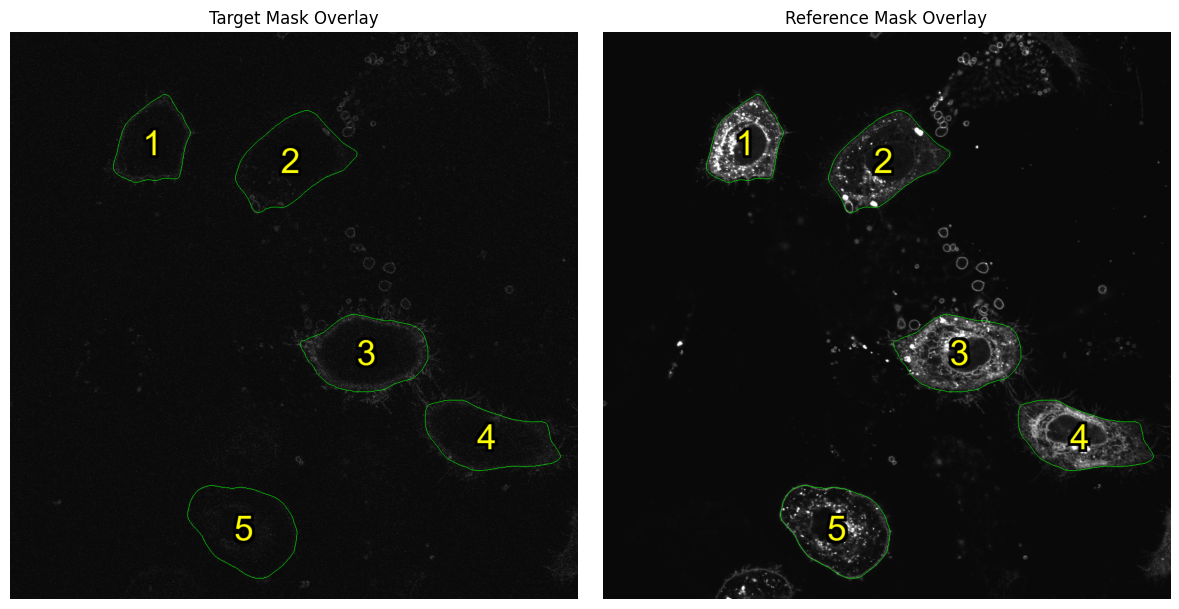

In [12]:
# Targetマスク適用
tgt_overlay, tgt_tiff, tgt_mask = apply_mask(
    target_img,
    masks,
    measure_channel=TARGET_MASK_PARAMS['channel'],
    sat_limit=TARGET_MASK_PARAMS['saturation_limit'],
    mask_mode=TARGET_MASK_PARAMS['mode'],
    pct=TARGET_MASK_PARAMS['percentile'],
    min_obj_size=TARGET_MASK_PARAMS['min_object_size'],
    mask_name="target_mask",
)

# Referenceマスク適用
ref_overlay, ref_tiff, ref_mask = apply_mask(
    reference_img,
    masks,
    measure_channel=REFERENCE_MASK_PARAMS['channel'],
    sat_limit=REFERENCE_MASK_PARAMS['saturation_limit'],
    mask_mode=REFERENCE_MASK_PARAMS['mode'],
    pct=REFERENCE_MASK_PARAMS['percentile'],
    min_obj_size=REFERENCE_MASK_PARAMS['min_object_size'],
    mask_name="reference_mask",
)

print("マスク適用完了")

# マスク結果を表示
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(tgt_overlay)
axes[0].set_title('Target Mask Overlay')
axes[0].axis('off')
axes[1].imshow(ref_overlay)
axes[1].set_title('Reference Mask Overlay')
axes[1].axis('off')
plt.tight_layout()
plt.show()


### Step 4: 定量化 (Integrate & Quantify)

In [13]:
# 定量化実行
result = integrate_and_quantify(
    target_img,
    reference_img,
    masks,
    tgt_mask,
    ref_mask,
    tgt_chan=TARGET_MASK_PARAMS['channel'],
    ref_chan=REFERENCE_MASK_PARAMS['channel'],
    pixel_width_um=QUANT_PARAMS['pixel_width_um'],
    pixel_height_um=QUANT_PARAMS['pixel_height_um'],
    pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
    pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
    pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
    pp_norm_method=PREPROCESS_PARAMS['norm_method'],
    bg_mode=PREPROCESS_PARAMS['bg_mode'],
    bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
    manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
    manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
    ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
)

(
    tgt_and_overlay, ref_and_overlay, and_mask_tiff,
    quant_df, quant_csv,
    tgt_on_and, ref_on_and, ratio_on_and
) = result

print(f"定量化完了: {len(quant_df)} 細胞")
print("\n定量化結果（最初の5行）:")
display(quant_df.head())


定量化完了: 5 細胞

定量化結果（最初の5行）:


,label,area_cell_px,area_cell_um2,area_and_px,area_and_um2,sum_target_on_mask,mean_target_on_mask,std_target_on_mask,sum_reference_on_mask,mean_reference_on_mask,...,sum_ratio_T_over_R,mean_ratio_T_over_R,std_ratio_T_over_R,ratio_of_means_on_mask,sum_target_whole,mean_target_whole,std_target_whole,sum_reference_whole,mean_reference_whole,std_reference_whole
0,1,15525,665.230725,15525,665.230725,96098.812500,6.189939,8.514772,1.099311e+06,70.809082,...,2.109262e+03,0.135862,0.265977,0.087417,96098.812500,6.189939,8.514772,1.099311e+06,70.809082,59.066746
1,2,23536,1008.494064,23536,1008.494064,104403.906250,4.435924,7.130138,6.971527e+05,29.620695,...,5.119521e+03,0.217519,0.441178,0.149758,104403.906250,4.435924,7.130138,6.971527e+05,29.620695,37.115353
2,3,23649,1013.336001,23649,1013.336001,248956.437500,10.527144,13.170105,1.425255e+06,60.267021,...,8.092806e+03,0.342205,6.022550,0.174675,248956.437500,10.527144,13.170105,1.425255e+06,60.267021,48.970444
3,4,21606,925.795494,21606,925.795494,158803.359375,7.349966,8.997001,1.134421e+06,52.504906,...,6.481065e+03,0.299966,5.612633,0.139986,158803.359375,7.349966,8.997001,1.134421e+06,52.504906,42.964180
4,5,23741,1017.278109,23741,1017.278109,102625.976562,4.322732,5.933729,6.867140e+05,28.925236,...,4.044655e+06,170.365806,26146.217210,0.149445,102625.976562,4.322732,5.933729,6.867140e+05,28.925236,37.794750


### Step 5: Radial Mask定量化

細胞の外周部分（radial ring）のみでの定量化を行います。

Radial Mask生成完了
  内側境界: 90.0%
  外側境界: 100.0%

Radial Mask定量化完了: 5 細胞

Radial Mask定量化結果（最初の5行）:


,label,area_cell_px,area_cell_um2,area_and_px,area_and_um2,sum_target_on_mask,mean_target_on_mask,std_target_on_mask,sum_reference_on_mask,mean_reference_on_mask,...,sum_ratio_T_over_R,mean_ratio_T_over_R,std_ratio_T_over_R,ratio_of_means_on_mask,sum_target_whole,mean_target_whole,std_target_whole,sum_reference_whole,mean_reference_whole,std_reference_whole
0,1,15525,665.230725,2575,110.336175,35726.367188,13.874317,11.442767,122907.007812,47.730877,...,981.655756,0.381226,0.483495,0.290678,96098.812500,6.189939,8.514772,1.099311e+06,70.809082,59.066746
1,2,23536,1008.494064,3524,150.999876,26402.476562,7.492190,8.611655,104422.070312,29.631689,...,1262.663173,0.358304,0.471421,0.252844,104403.906250,4.435924,7.130138,6.971527e+05,29.620695,37.115353
2,3,23649,1013.336001,3707,158.841243,75975.343750,20.495102,16.156843,148452.609375,40.046562,...,4516.966988,1.218497,15.169221,0.511782,248956.437500,10.527144,13.170105,1.425255e+06,60.267021,48.970444
3,4,21606,925.795494,3146,134.802954,43789.250000,13.919024,11.637997,109346.515625,34.757317,...,3057.983319,0.972023,14.670694,0.400463,158803.359375,7.349966,8.997001,1.134421e+06,52.504906,42.964180
4,5,23741,1017.278109,3904,167.282496,21190.210938,5.427820,6.700744,132694.343750,33.989330,...,1491.043927,0.381927,6.365214,0.159692,102625.976562,4.322732,5.933729,6.867140e+05,28.925236,37.794750


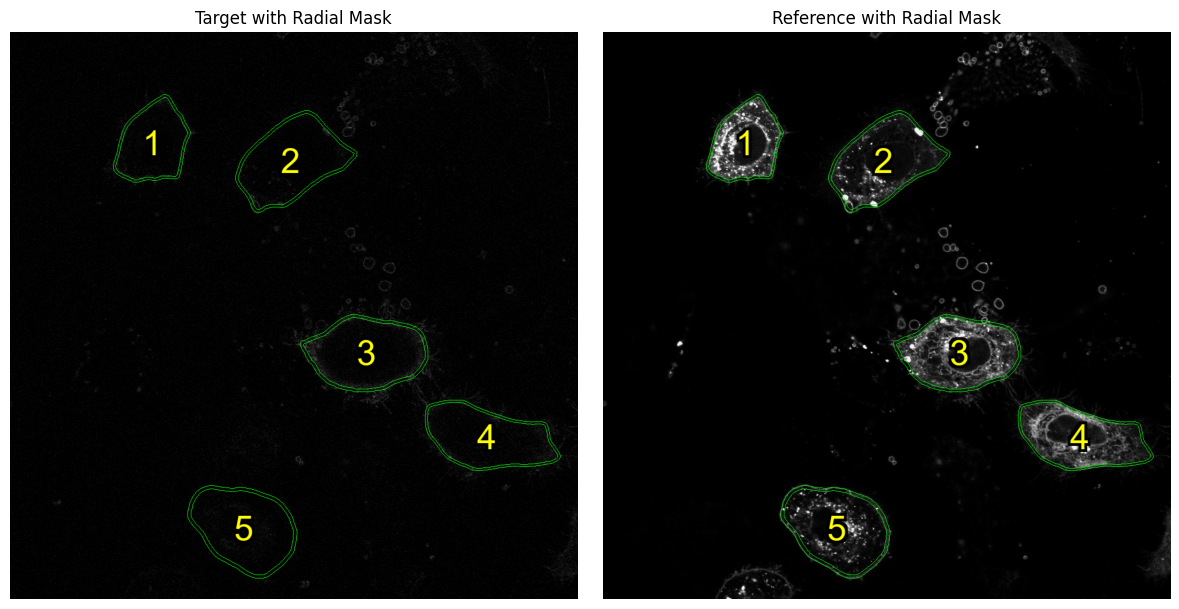

In [14]:

# 1. Radial Maskを生成
radial_overlay, radial_bool_mask, radial_label_mask, radial_bool_tiff, radial_label_tiff = radial_mask(
    masks=masks,
    inner_pct=RADIAL_MASK_PARAMS['inner_pct'],
    outer_pct=RADIAL_MASK_PARAMS['outer_pct'],
    min_obj_size=RADIAL_MASK_PARAMS['min_object_size'],
)

print(f"Radial Mask生成完了")
print(f"  内側境界: {RADIAL_MASK_PARAMS['inner_pct']}%")
print(f"  外側境界: {RADIAL_MASK_PARAMS['outer_pct']}%")

# # Radial Maskを表示
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# axes[0].imshow(radial_overlay)
# axes[0].set_title('Radial Mask Overlay')
# axes[0].axis('off')
# axes[1].imshow(radial_bool_mask, cmap='gray')
# axes[1].set_title('Radial Mask (Boolean)')
# axes[1].axis('off')
# plt.tight_layout()
# plt.show()

# 2. Radial Maskを使った定量化
# Target/Reference maskの代わりにradial maskを使い、roi_mask/roi_labelsも指定
radial_quant_result = integrate_and_quantify(
    target_img,
    reference_img,
    masks,
    tgt_mask,  # Target mask（通常のマスク）
    ref_mask,  # Reference mask（通常のマスク）
    tgt_chan=TARGET_MASK_PARAMS['channel'],
    ref_chan=REFERENCE_MASK_PARAMS['channel'],
    pixel_width_um=QUANT_PARAMS['pixel_width_um'],
    pixel_height_um=QUANT_PARAMS['pixel_height_um'],
    pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
    pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
    pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
    pp_norm_method=PREPROCESS_PARAMS['norm_method'],
    bg_mode=PREPROCESS_PARAMS['bg_mode'],
    bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
    manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
    manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
    ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
    roi_mask=radial_bool_mask,  # Radial MaskをROIとして指定
    roi_labels=radial_label_mask,  # Radial LabelをROIラベルとして指定
)

(
    radial_tgt_and_overlay, radial_ref_and_overlay, radial_and_mask_tiff,
    radial_quant_df, radial_quant_csv,
    radial_tgt_on_and, radial_ref_on_and, radial_ratio_on_and
) = radial_quant_result

print(f"\nRadial Mask定量化完了: {len(radial_quant_df)} 細胞")
print("\nRadial Mask定量化結果（最初の5行）:")
display(radial_quant_df.head())

# Radial Maskを適用したオーバーレイ画像を表示
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(radial_tgt_and_overlay)
axes[0].set_title('Target with Radial Mask')
axes[0].axis('off')
axes[1].imshow(radial_ref_and_overlay)
axes[1].set_title('Reference with Radial Mask')
axes[1].axis('off')
plt.tight_layout()
plt.show()


### Step 5-1: EDT (Euclidean Distance Transform) 解析

細胞マスクに対してEDTを計算し、距離ベースの図を作成します。


EDT計算完了
  最大距離: 72.47 pixels
  平均距離: 24.34 pixels


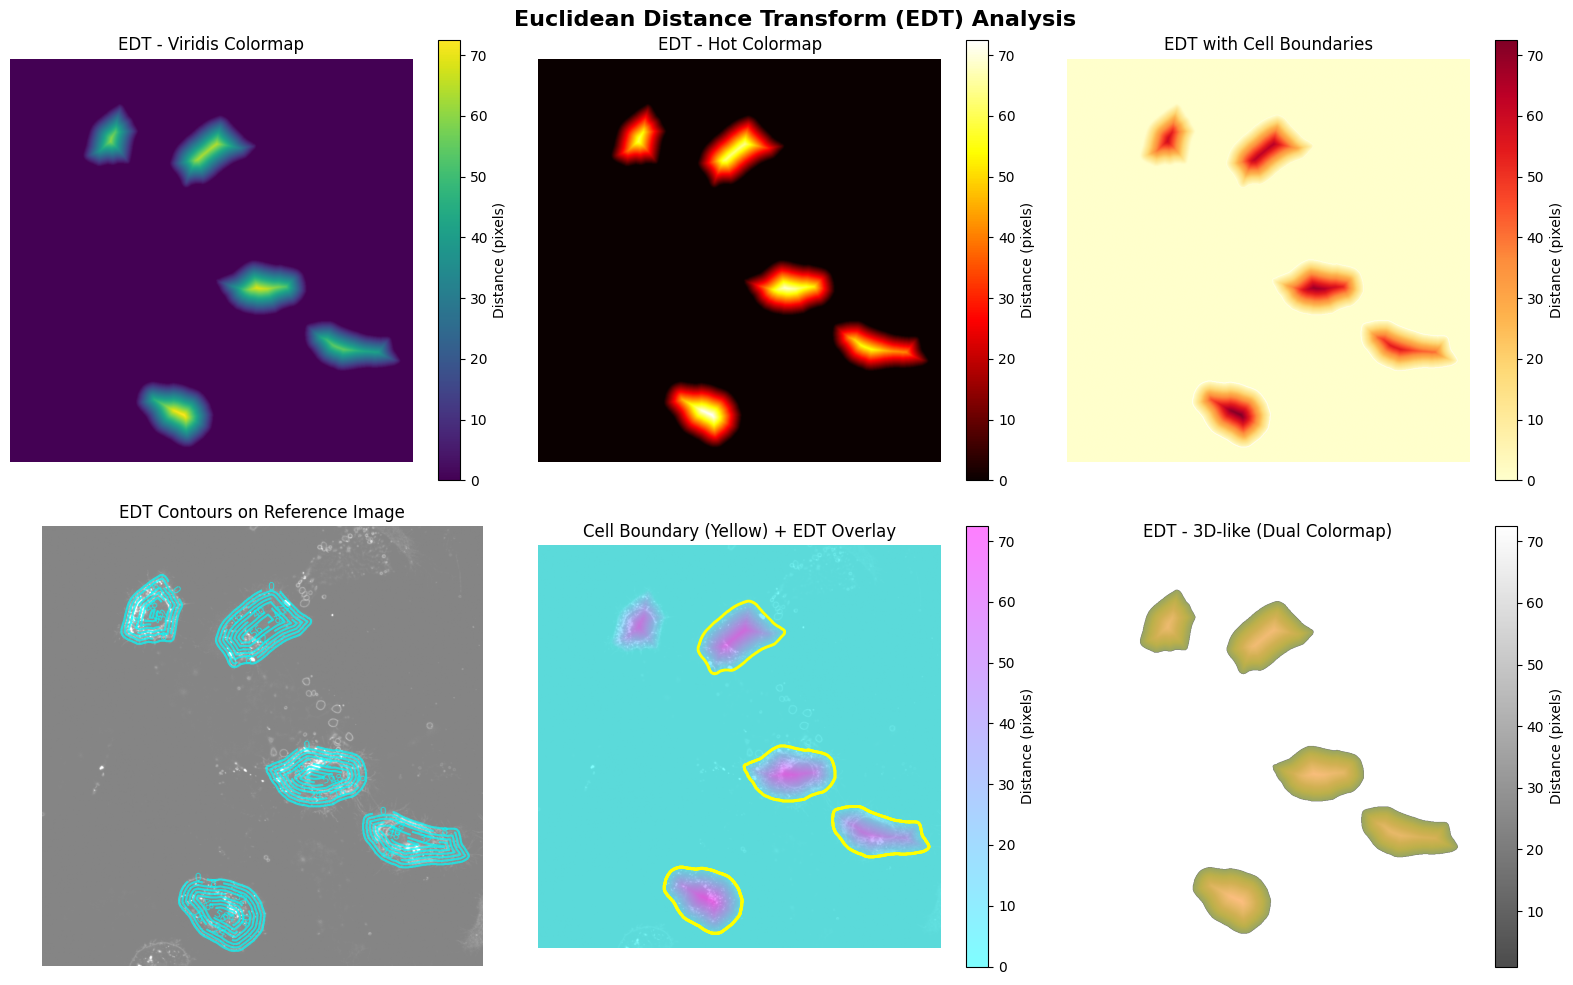


✓ EDT可視化完了


In [15]:
from scipy.ndimage import distance_transform_edt
import matplotlib.patches as mpatches
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# 1. マスクからEDTを計算
edt_result, _ = distance_transform_edt(masks > 0, return_indices=True)

print(f"EDT計算完了")
print(f"  最大距離: {edt_result.max():.2f} pixels")
print(f"  平均距離: {edt_result[masks > 0].mean():.2f} pixels")

# 2. 複数の可視化パターンを作成
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Euclidean Distance Transform (EDT) Analysis', fontsize=16, fontweight='bold')

# パターン1: EDT熱図（viridis）
im1 = axes[0, 0].imshow(edt_result, cmap='viridis')
axes[0, 0].set_title('EDT - Viridis Colormap', fontsize=12)
axes[0, 0].axis('off')
plt.colorbar(im1, ax=axes[0, 0], label='Distance (pixels)')

# パターン2: EDT熱図（hot）- 論文向け
im2 = axes[0, 1].imshow(edt_result, cmap='hot')
axes[0, 1].set_title('EDT - Hot Colormap', fontsize=12)
axes[0, 1].axis('off')
plt.colorbar(im2, ax=axes[0, 1], label='Distance (pixels)')

# パターン3: セグメンテーション輪郭 + EDTオーバーレイ
masked_edt = np.where(masks > 0, edt_result, 0)
im3 = axes[0, 2].imshow(masked_edt, cmap='YlOrRd')
# セグメンテーション輪郭を白線で追加
from skimage import segmentation
seg_edges = segmentation.find_boundaries(masks, mode='inner')
axes[0, 2].contour(masks, levels=np.unique(masks)[1:], colors='white', linewidths=0.5, alpha=0.3)
axes[0, 2].set_title('EDT with Cell Boundaries', fontsize=12)
axes[0, 2].axis('off')
plt.colorbar(im3, ax=axes[0, 2], label='Distance (pixels)')

# パターン4: グレースケール + 等距離線（等高線）
axes[1, 0].imshow(reference_img, cmap='gray', alpha=0.5)
contours = axes[1, 0].contour(edt_result, levels=10, colors='cyan', linewidths=1.5, alpha=0.7)
axes[1, 0].clabel(contours, inline=True, fontsize=8)
axes[1, 0].set_title('EDT Contours on Reference Image', fontsize=12)
axes[1, 0].axis('off')

# パターン5: マスクの輪郭 + エッジの距離分布
axes[1, 1].imshow(reference_img, cmap='gray', alpha=0.3)
axes[1, 1].contour(masks, levels=np.unique(masks)[1:], colors='yellow', linewidths=2)
# 距離値の高い領域を強調
im5 = axes[1, 1].imshow(masked_edt, cmap='cool', alpha=0.5)
axes[1, 1].set_title('Cell Boundary (Yellow) + EDT Overlay', fontsize=12)
axes[1, 1].axis('off')
plt.colorbar(im5, ax=axes[1, 1], label='Distance (pixels)')

# パターン6: 3D-like表現（影付き）
masked_edt_display = np.where(masks > 0, edt_result, np.nan)
im6 = axes[1, 2].imshow(masked_edt_display, cmap='gray', alpha=0.7)
axes[1, 2].imshow(masked_edt_display, cmap='Wistia', alpha=0.5)
axes[1, 2].set_title('EDT - 3D-like (Dual Colormap)', fontsize=12)
axes[1, 2].axis('off')
plt.colorbar(im6, ax=axes[1, 2], label='Distance (pixels)')

plt.tight_layout()
plt.show()

print("\n✓ EDT可視化完了")


### Step 5-2: 特定細胞のEDT解析（細胞1, 2）

細胞1と2の周辺領域を切り取り、詳細なEDT解析を行います。

切り取り領域: Y[64:378], X[136:676]
領域サイズ: 314 × 540 pixels


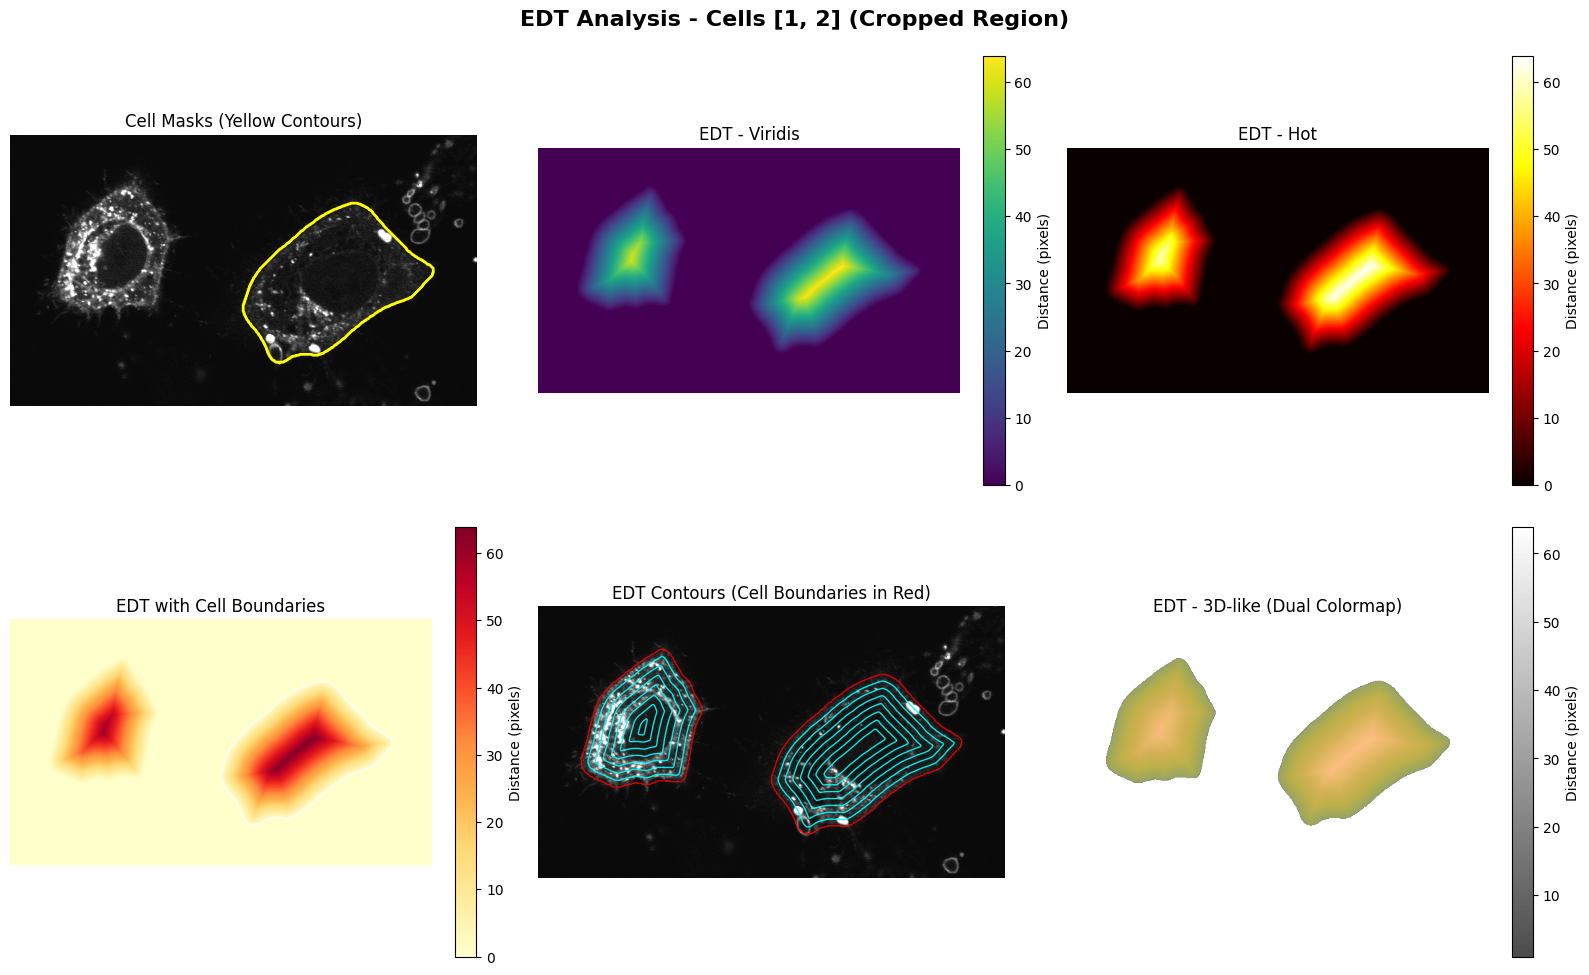


細胞[1, 2]のEDT統計:
  細胞1:
    最大距離: 59.30 pixels
    平均距離: 21.36 pixels
    中央値: 19.00 pixels
    面積: 15525 pixels²
  細胞2:
    最大距離: 63.82 pixels
    平均距離: 25.01 pixels
    中央値: 22.63 pixels
    面積: 23536 pixels²


In [16]:
from scipy.ndimage import find_objects, gaussian_filter

# 細胞1と2の周辺を切り取る関数
def crop_cell_region(masks, cell_labels, padding=50):
    """
    指定した細胞ラベルの周辺領域を切り取る
    
    Parameters:
    -----------
    masks : np.ndarray
        細胞マスク
    cell_labels : list
        切り取る細胞のラベル番号
    padding : int
        細胞周辺のパディング（ピクセル数）
    
    Returns:
    --------
    bbox : tuple
        切り取り領域 (y_min, y_max, x_min, x_max)
    """
    # 指定細胞のマスク領域を取得
    combined_mask = np.isin(masks, cell_labels)
    
    # バウンディングボックスを取得
    slices = find_objects(combined_mask.astype(int))
    if not slices or slices[0] is None:
        return None
    
    y_slice, x_slice = slices[0]
    
    # パディングを追加
    h, w = masks.shape
    y_min = max(0, y_slice.start - padding)
    y_max = min(h, y_slice.stop + padding)
    x_min = max(0, x_slice.start - padding)
    x_max = min(w, x_slice.stop + padding)
    
    return (y_min, y_max, x_min, x_max)

# 細胞1と2の領域を切り取り
target_cells = [1, 2]
bbox = crop_cell_region(masks, target_cells, padding=50)

if bbox is None:
    print("細胞1または2が見つかりません")
else:
    y_min, y_max, x_min, x_max = bbox
    print(f"切り取り領域: Y[{y_min}:{y_max}], X[{x_min}:{x_max}]")
    print(f"領域サイズ: {y_max - y_min} × {x_max - x_min} pixels")
    
    # 各データを切り取り
    masks_crop = masks[y_min:y_max, x_min:x_max]
    ref_img_crop = np.array(reference_img)[y_min:y_max, x_min:x_max]
    
    # EDTを計算（マスク領域内のみ）
    edt_crop, _ = distance_transform_edt(masks_crop > 0, return_indices=True)
    
    # 等距離線用に平滑化したEDT（マスク外はNaNにして輪郭線を綺麗に）
    edt_smooth = gaussian_filter(edt_crop.astype(float), sigma=1.0)
    edt_for_contour = np.where(masks_crop > 0, edt_smooth, np.nan)
    
    masked_edt_crop = np.where(masks_crop > 0, edt_crop, 0)
    
    # 可視化
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    fig.suptitle(f'EDT Analysis - Cells {target_cells} (Cropped Region)', fontsize=16, fontweight='bold')
    
    # 1. セグメンテーションマスク
    axes[0, 0].imshow(ref_img_crop, cmap='gray')
    axes[0, 0].contour(masks_crop, levels=np.unique(masks_crop)[1:], colors='yellow', linewidths=2)
    axes[0, 0].set_title('Cell Masks (Yellow Contours)', fontsize=12)
    axes[0, 0].axis('off')
    
    # 2. EDT熱図（viridis）
    im2 = axes[0, 1].imshow(edt_crop, cmap='viridis')
    axes[0, 1].set_title('EDT - Viridis', fontsize=12)
    axes[0, 1].axis('off')
    plt.colorbar(im2, ax=axes[0, 1], label='Distance (pixels)', fraction=0.046)
    
    # 3. EDT熱図（hot）
    im3 = axes[0, 2].imshow(edt_crop, cmap='hot')
    axes[0, 2].set_title('EDT - Hot', fontsize=12)
    axes[0, 2].axis('off')
    plt.colorbar(im3, ax=axes[0, 2], label='Distance (pixels)', fraction=0.046)
    
    # 4. EDT + 細胞輪郭（YlOrRd）
    im4 = axes[1, 0].imshow(masked_edt_crop, cmap='YlOrRd')
    axes[1, 0].contour(masks_crop, levels=np.unique(masks_crop)[1:], colors='white', linewidths=1.5, alpha=0.6)
    axes[1, 0].set_title('EDT with Cell Boundaries', fontsize=12)
    axes[1, 0].axis('off')
    plt.colorbar(im4, ax=axes[1, 0], label='Distance (pixels)', fraction=0.046)
    
    # 5. 等距離線（等高線）- 平滑化版、マスク外を除外
    # 元画像をそのまま表示（グレースケールまたはRGB）
    if len(ref_img_crop.shape) == 3:
        axes[1, 1].imshow(ref_img_crop)
    else:
        axes[1, 1].imshow(ref_img_crop, cmap='gray')
    # NaNを考慮して等高線を描画（マスク内のみ滑らかに表示）
    contours = axes[1, 1].contour(edt_for_contour, levels=8, colors='cyan', linewidths=1, alpha=0.9)
    # axes[1, 1].clabel(contours, inline=True, fontsize=10, fmt='%.1f', inline_spacing=3)
    # 細胞1と2の輪郭を赤色で描画
    for cell_id in target_cells:
        cell_contour = (masks_crop == cell_id).astype(float)
        axes[1, 1].contour(cell_contour, levels=[0.5], colors='red', linewidths=1, alpha=0.8)
    axes[1, 1].set_title('EDT Contours (Cell Boundaries in Red)', fontsize=12)
    axes[1, 1].axis('off')
    
    # 6. 3D-like表現
    masked_edt_display = np.where(masks_crop > 0, edt_crop, np.nan)
    im6 = axes[1, 2].imshow(masked_edt_display, cmap='gray', alpha=0.7)
    axes[1, 2].imshow(masked_edt_display, cmap='Wistia', alpha=0.5)
    axes[1, 2].set_title('EDT - 3D-like (Dual Colormap)', fontsize=12)
    axes[1, 2].axis('off')
    plt.colorbar(im6, ax=axes[1, 2], label='Distance (pixels)', fraction=0.046)
    
    plt.tight_layout()
    plt.show()
    
    # 統計情報
    print(f"\n細胞{target_cells}のEDT統計:")
    for cell_id in target_cells:
        cell_edt = edt_crop[masks_crop == cell_id]
        if len(cell_edt) > 0:
            print(f"  細胞{cell_id}:")
            print(f"    最大距離: {cell_edt.max():.2f} pixels")
            print(f"    平均距離: {cell_edt.mean():.2f} pixels")
            print(f"    中央値: {np.median(cell_edt):.2f} pixels")
            print(f"    面積: {len(cell_edt)} pixels²")


### Step 6: Radial Profile 解析


In [17]:
# Radial Profile解析実行
radial_df, radial_csv = radial_profile_all_cells(
    target_img,
    reference_img,
    masks,
    tgt_chan=TARGET_MASK_PARAMS['channel'],
    ref_chan=REFERENCE_MASK_PARAMS['channel'],
    start_pct=RADIAL_PARAMS['start_pct'],
    end_pct=RADIAL_PARAMS['end_pct'],
    window_size_pct=RADIAL_PARAMS['window_size_pct'],
    window_step_pct=RADIAL_PARAMS['window_step_pct'],
    pp_bg_enable=PREPROCESS_PARAMS['bg_enable'],
    pp_bg_radius=PREPROCESS_PARAMS['bg_radius'],
    pp_norm_enable=PREPROCESS_PARAMS['norm_enable'],
    pp_norm_method=PREPROCESS_PARAMS['norm_method'],
    bg_mode=PREPROCESS_PARAMS['bg_mode'],
    bg_dark_pct=PREPROCESS_PARAMS['bg_dark_pct'],
    manual_tar_bg=PREPROCESS_PARAMS['manual_tar_bg'],
    manual_ref_bg=PREPROCESS_PARAMS['manual_ref_bg'],
    ratio_ref_epsilon=QUANT_PARAMS['ratio_epsilon'],
)

print(f"Radial Profile解析完了: {len(radial_df)} データポイント")
print("\nRadial Profile結果（最初の5行）:")
display(radial_df.head())

Radial Profile解析完了: 730 データポイント

Radial Profile結果（最初の5行）:


,label,band_start_pct,band_end_pct,center_pct,count_px,mean_target,mean_reference,std_target,std_reference,sem_target,sem_reference,mean_ratio_T_over_R,std_ratio_T_over_R,sem_ratio_T_over_R,count_ratio_px
0,1,0.0,5.0,2.5,96,1.580445,16.701865,2.875971,5.380349,0.293528,0.549130,0.104826,0.213859,0.021827,96
1,1,1.0,6.0,3.5,120,1.853698,16.772691,2.955161,5.222240,0.269768,0.476723,0.125445,0.237360,0.021668,120
2,1,2.0,7.0,4.5,134,1.938945,16.827785,3.004895,5.225451,0.259583,0.451410,0.123267,0.213696,0.018461,134
3,1,3.0,8.0,5.5,162,2.022212,17.131606,3.186752,5.708076,0.250375,0.448469,0.129263,0.230266,0.018091,162
4,1,4.0,9.0,6.5,176,2.090755,17.196134,3.701981,5.804925,0.279047,0.437563,0.128028,0.241714,0.018220,176


### Step 7: Peak Difference 解析

In [18]:
# Peak Difference解析実行 (SG + first_local_top対応)
peak_df = compute_radial_peak_difference(
    radial_df,
    quant_df=quant_df,
    algo=PEAK_PARAMS['algo'],
    min_pct=PEAK_PARAMS['min_pct'],
    max_pct=PEAK_PARAMS['max_pct'],
    sg_window=PEAK_PARAMS['sg_window'],
    sg_poly=PEAK_PARAMS['sg_poly'],
    peak_slope_eps_rel=PEAK_PARAMS['peak_slope_eps_rel'],
)

print(f"Peak Difference解析完了: {len(peak_df)} 細胞")
print("\nPeak Difference結果:")
display(peak_df)

# 統計情報
if not peak_df.empty and 'difference_pct' in peak_df.columns:
    print(f"\nPeak Difference統計:")
    print(f"  平均: {peak_df['difference_pct'].mean():.2f} %")
    print(f"  中央値: {peak_df['difference_pct'].median():.2f} %")
    print(f"  標準偏差: {peak_df['difference_pct'].std():.2f} %")


Peak Difference解析完了: 5 細胞

Peak Difference結果:


,label,max_target_center_pct,max_reference_center_pct,difference_pct,max_target_px,max_reference_px,difference_px,max_target_um,max_reference_um,difference_um,max_target_intensity,max_reference_intensity,ratio_intensity,ref_range_rel,ref_noise_rel,ref_neg_run_after_peak,accept_ref
0,1,93.5,67.5,26.0,65.728312,47.450920,18.277392,13.605761,9.822341,3.783420,15.698117,105.222654,0.149190,0.807525,0.012443,32,True
1,2,89.5,83.5,6.0,77.466588,72.273297,5.193291,16.035584,14.960572,1.075011,8.694641,50.059262,0.173687,0.676457,0.046049,0,False
2,3,90.5,82.5,8.0,78.519953,71.578963,6.940990,16.253630,14.816845,1.436785,24.481179,83.243563,0.294091,0.724912,0.037474,17,True
3,4,93.5,85.5,8.0,77.539654,70.905245,6.634409,16.050708,14.677386,1.373323,14.589650,61.028906,0.239061,0.742993,0.027047,14,True
4,5,98.5,98.5,0.0,85.627014,85.627014,0.000000,17.724792,17.724792,0.000000,6.895842,46.034785,0.149796,0.672018,0.024758,1,False



Peak Difference統計:
  平均: 9.60 %
  中央値: 8.00 %
  標準偏差: 9.74 %


### Step 7-1: Radial Profile グラフの生成（全ラベル）


5 個の細胞についてRadial Profileグラフを生成中...


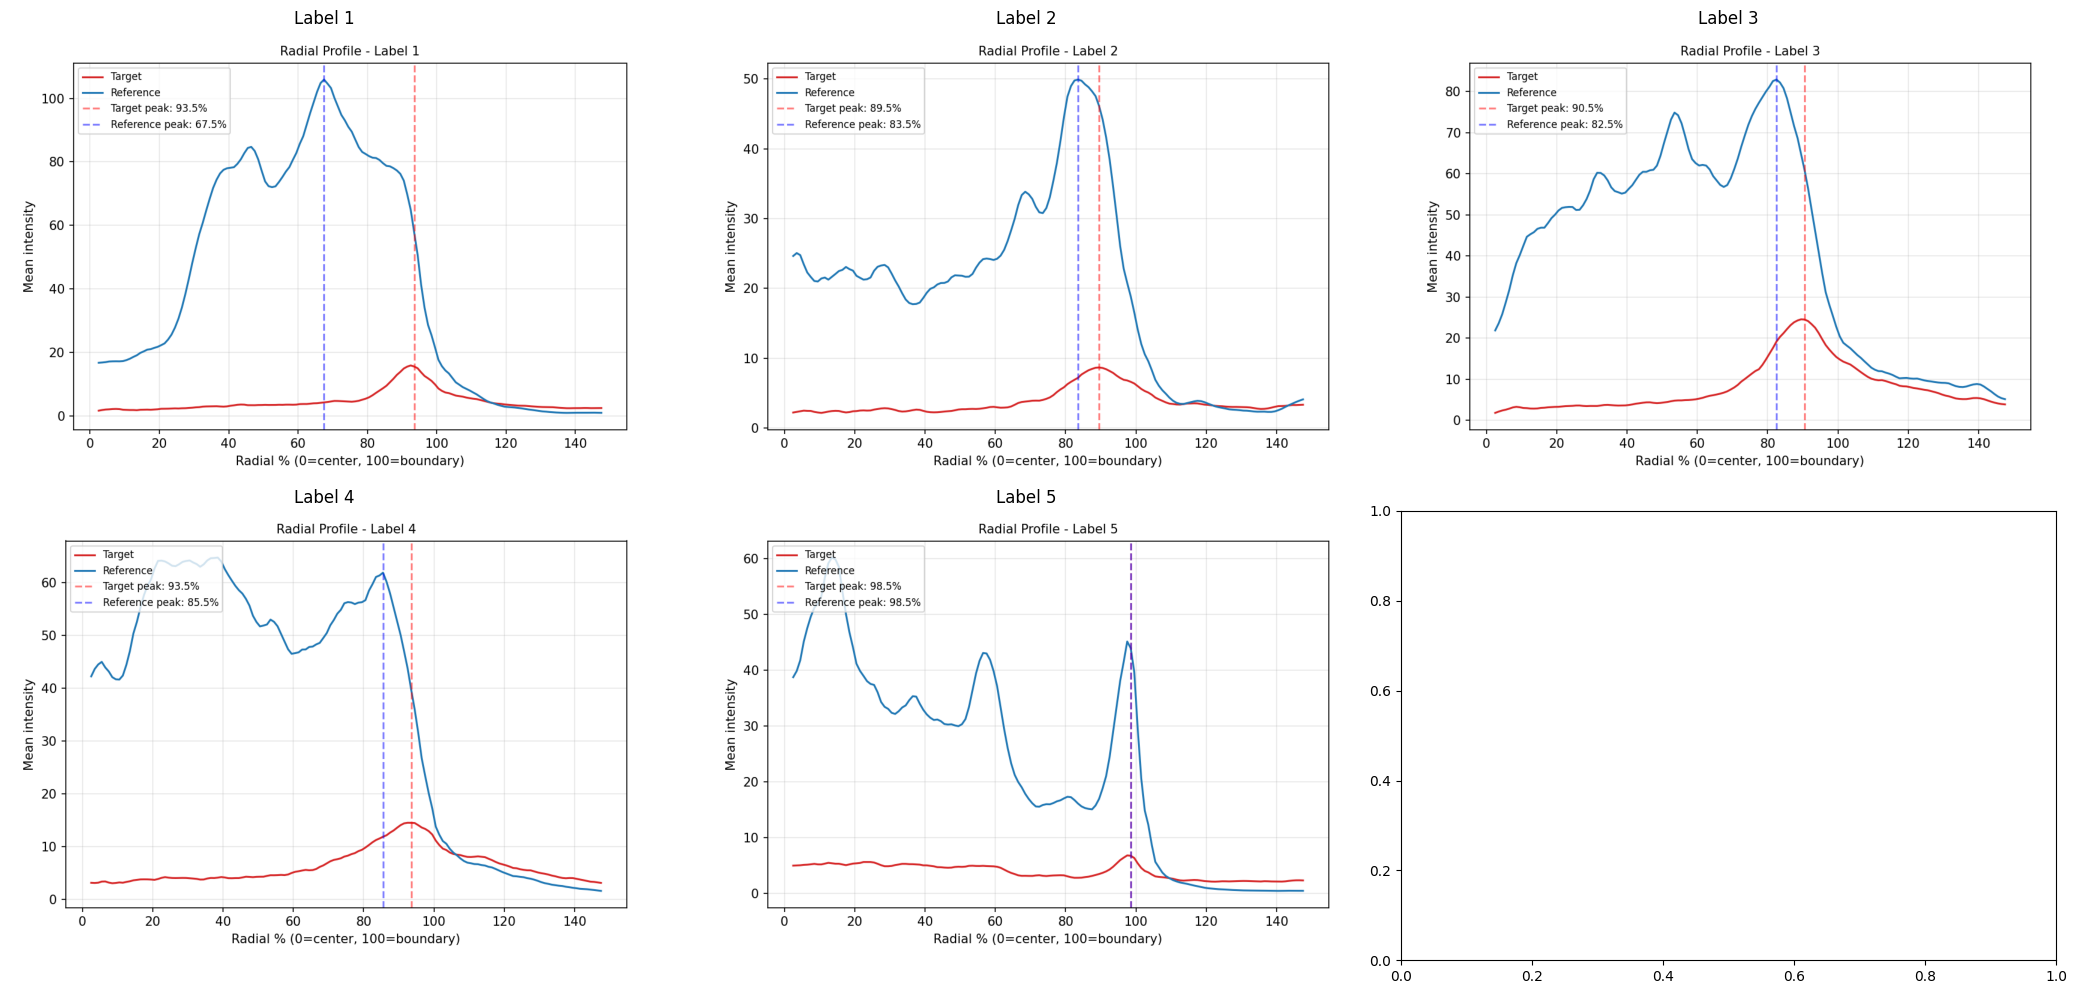

In [19]:
# すべてのラベルについてRadial Profileグラフを生成（T/Rは表示しない）
if not radial_df.empty and not peak_df.empty:
    # ユニークなラベルを取得
    unique_labels = sorted(radial_df['label'].unique())
    
    print(f"\n{len(unique_labels)} 個の細胞についてRadial Profileグラフを生成中...")
    
    
    # グラフを3列ずつすべて表示
    
    if unique_labels:
        n_column = 3
        n_row = (len(unique_labels) + n_column - 1) // n_column
        
        fig, axes = plt.subplots(n_row, n_column, figsize=(7 * n_column, 5 * n_row))
        axes = axes.flatten()  # 2D配列を1Dに変換

        for i, label in enumerate(unique_labels):
            plot_img = plot_radial_profile_with_peaks(
                df=radial_df,
                peak_df=peak_df,
                label_filter=label,
                window_bins=1,
                show_errorbars=False,
                show_ratio=False,
            )
            axes[i].imshow(plot_img)
            axes[i].axis('off')
            axes[i].set_title(f'Label {label}', fontsize=12)
        
        plt.tight_layout()
        plt.show()
else:
    print("Radial ProfileまたはPeak Differenceデータがありません")

In [20]:
radial_df[radial_df['label'] == 2].copy()

,label,band_start_pct,band_end_pct,center_pct,count_px,mean_target,mean_reference,std_target,std_reference,sem_target,sem_reference,mean_ratio_T_over_R,std_ratio_T_over_R,sem_ratio_T_over_R,count_ratio_px
146,2,0.0,5.0,2.5,374,2.255550,24.476155,4.375565,44.356654,0.226255,2.293628,0.163096,0.343691,0.017772,374
147,2,1.0,6.0,3.5,460,2.265350,25.346110,4.270420,44.054828,0.199109,2.054067,0.157134,0.332193,0.015489,460
148,2,2.0,7.0,4.5,494,2.481907,24.928523,4.720427,41.690473,0.212382,1.875743,0.173685,0.387629,0.017440,494
149,2,3.0,8.0,5.5,485,2.430405,23.269379,4.728955,37.204992,0.214731,1.689392,0.163450,0.375416,0.017047,485
150,2,4.0,9.0,6.5,488,2.546658,22.274054,4.708614,33.198756,0.213149,1.502837,0.175291,0.383052,0.017340,488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,2,141.0,146.0,143.5,2513,3.266990,3.316405,6.733297,12.860807,0.134317,0.256550,17009.195710,393851.339299,7856.626045,2513
288,2,142.0,147.0,144.5,2556,3.319293,3.488155,7.177453,13.291367,0.141968,0.262899,14008.829862,349723.658764,6917.427061,2556
289,2,143.0,148.0,145.5,2596,3.303285,3.740120,7.149720,13.984121,0.140326,0.274462,15300.440462,364414.888659,7152.267817,2596
290,2,144.0,149.0,146.5,2549,3.299715,3.979045,7.158319,14.437702,0.141784,0.285965,16734.575820,376755.384072,7462.331703,2549


### 論文用図: Label 2のRadial Profile（カスタム）

Reference（赤）とTarget（緑）のみ、ピーク点線なし、軸ラベル大きく、凡例なし

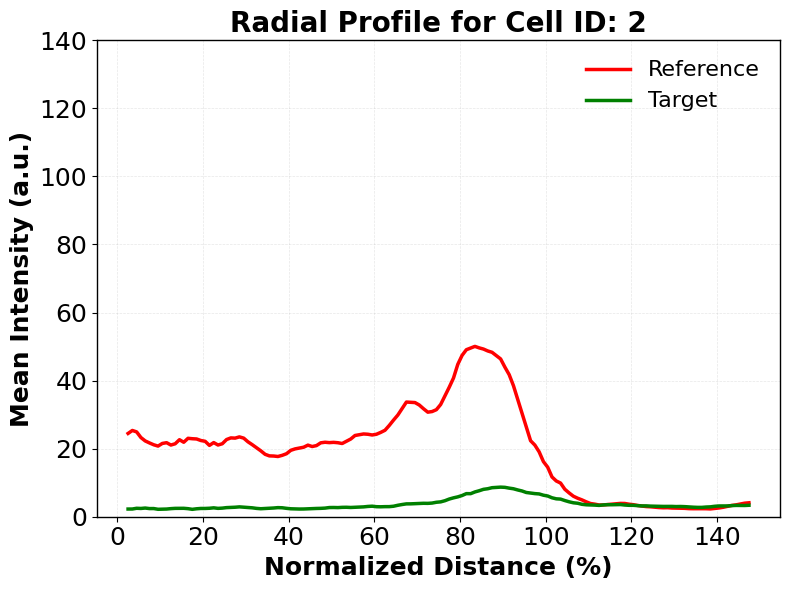

✓ Label 2のRadial Profile（論文用）を作成しました
  データポイント数: 146
  距離範囲: 2.5% - 147.5%


In [ ]:
# Label 2のRadial Profileデータを取得
label_2_data = radial_df[radial_df['label'] == 2].copy()

if label_2_data.empty:
    print("Label 2のデータが見つかりません")
else:
    # データをソート
    label_2_data = label_2_data.sort_values('center_pct')
    
    # 図を作成（論文用：シンプル、大きな軸ラベル）
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    
    # Reference（赤）とTarget（緑）のプロット
    ax.plot(label_2_data['center_pct'], label_2_data['mean_reference'], 
            color='red', linewidth=2.5, label='Reference')
    ax.plot(label_2_data['center_pct'], label_2_data['mean_target'], 
            color='green', linewidth=2.5, label='Target')
    
    # 軸ラベル（大きく）
    ax.set_ylim(0, 140)
    ax.set_title('Radial Profile for Cell ID: 2', fontsize=20, fontweight='bold')
    ax.set_xlabel('Normalized Distance (%)', fontsize=18, fontweight='bold')
    ax.set_ylabel('Mean Intensity (a.u.)', fontsize=18, fontweight='bold')
    
    # 軸の目盛りラベルも大きく
    ax.tick_params(axis='both', which='major', labelsize=18)
    
    # グリッド（薄く）
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    # 凡例を表示（大きなフォント、枠なし）
    ax.legend(fontsize=16, frameon=False, loc='best')
    
    # スパイン（枠線）を太く
    for spine in ax.spines.values():
        spine.set_linewidth(1)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Label 2のRadial Profile（論文用）を作成しました")
    print(f"  データポイント数: {len(label_2_data)}")
    print(f"  距離範囲: {label_2_data['center_pct'].min():.1f}% - {label_2_data['center_pct'].max():.1f}%")